*This notebook is adapted from [Elegant SciPy by By Juan Nunez-Iglesias, Stéfan van der Walt, and Harriet Dashnow](http://shop.oreilly.com/product/0636920038481.do) and from [The Python Data Science Handbook by Jake VanderPlas](http://shop.oreilly.com/product/0636920034919.do).*

*Both books are available on Github:  
https://github.com/elegant-scipy  
https://github.com/jakevdp/PythonDataScienceHandbook*

*The text of Elegant Scipy is released under the [cc0](https://github.com/elegant-scipy/notebooks/blob/master/LICENSE.md) license and the code is released under [BSD](https://github.com/elegant-scipy/notebooks/blob/master/LICENSE-CODE.md) license.  The text of The Python Data Science Handbook is released under the [CC0](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/LICENSE-TEXT) license and the code is released under [MIT](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/LICENSE-CODE) license.*

# (Re)Introduction to Numpy

### Questions
- How can I normalize my data?

### Objectives
- Understand why we would use Numpy arrays instead of built-in Python data structures such as lists
- Know what vectorization is
- Know what broadcasting is
- Read tabular data from a file using Pandas

This lesson focuses on exploring the NumPy array, a data structure that underlies almost all numerical scientific computation in Python.
We will see how NumPy array operations enable concise and efficient code when manipulating numerical data.

Our use case is using gene expression data from The Cancer Genome Atlas (TCGA) project to predict mortality in skin cancer patients.  
Before we can predict mortality, we will need to normalize the expression data using a method called RPKM normalization.  
This allows the comparison of measurements between different samples and genes.
(We will unpack what "gene expression" means in just a moment.)

By the end of the lesson, we will have written a function that computes RPKM normalization, taking advantage of NumPy's **vectorization** and **broadcasting** rules, which allow us to manipulate and reason about data arrays very efficiently.

## Introduction to the data: what is gene expression?

We will work our way through a *gene expression analysis* to demonstrate the power of NumPy and SciPy to solve a real-world biological problem.  
The amount of mRNA produced from a given gene is called the *expression* of that gene.
We are using mRNA levels for their power to predict biological outcomes, rather than to make specific statements about proteins.
We will use the Pandas library, which builds on NumPy, to read and munge our data files, and then we manipulate our data efficiently in NumPy arrays.  

### the central dogma

Recall the Central Dogma of Molecular Biology, which states that information flows from DNA to RNA, in transcription, and then from RNA to protein, in translation. According to this dogma, we should be able to say something about protein levels by looking at RNA expression levels.

<img src="./figures/central_dogma.png"/>
<!-- caption text="Central Dogma of Molecular Biology" -->

### differential expression

It's important to note that the DNA in every cell of your body is identical.
Thus, the differences between cells arise from *differential expression* of
that DNA into RNA: in different cells, different parts of the DNA are processed
into downstream molecules. Similarly, as we shall see in this chapter and the
next, differential expression can distinguish different kinds of cancer.

<img src="./figures/differential_gene_expression.png"/>
<!-- caption text="Gene expression" -->

### RNAseq

The state-of-the-art technology to measure mRNA is RNA sequencing (RNAseq).
RNA is extracted from a tissue sample, for example from a biopsy from a patient, *reverse transcribed* back into DNA (which is more stable), and then read out using chemically modified bases that glow when they are incorporated into the DNA sequence.
Currently, high-throughput sequencing machines can only read short fragments (approximately 100 bases is common). These short sequences are called “reads”.
We measure millions of reads and then based on their sequence we count how many reads came from each gene.
We’ll be starting directly from this count data.

<img src="./figures/RNAseq.png"/>
<!-- caption text="RNA sequencing (RNAseq)" -->

Here's an example of what this gene expression data looks like.

|        | Cell type A | Cell type B |
|--------|-------------|-------------|
| Gene 0 | 100         | 200         |
| Gene 1 | 50          | 0           |
| Gene 2 | 350         | 100         |

The data is a table of counts, integers representing how many reads were observed for each gene in each cell type.
See how the counts for each gene differ between the cell types?
We can use this information to tell us about the differences between these two types of cell.

## Why do we use Numpy instead of Python?

One way to represent gene expression data in Python would be as a list of lists:

In [1]:
gene0 = [100, 200]
gene1 = [50, 0]
gene2 = [350, 100]
expression_data = [gene0, gene1, gene2]

Above, each gene's expression across different cell types is stored in a list of Python integers.
Then, we store all of these lists in a list (a meta-list, if you will).
We can retrieve individual data points using two levels of list indexing:

In [2]:
expression_data[2][0]

350

It turns out that, because of the way the Python interpreter works, this is a very inefficient way to store these data points.
First, Python lists are always lists of *objects*, so that the above list `gene2` is not a list of integers, but a list of *pointers* to integers, which is unnecessary overhead.
Additionally, this means that each of these lists and each of these integers end up in a completely different, random part of your computer's RAM.
However, modern processors actually like to retrieve things from memory in *chunks*, so this spreading of the data throughout the RAM is inefficient.

Let's look at this more closely.

### A Python Integer Is More Than Just an Integer

The standard Python implementation is written in C.
This means that every Python object is simply a cleverly-disguised C structure, which contains not only its value, but other information as well. For example, when we define an integer in Python, such as ``x = 10000``, ``x`` is not just a "raw" integer. It's actually a pointer to a compound C structure, which contains several values.
Looking through the Python 3.4 source code, we find that the integer (long) type definition effectively looks like this (once the C macros are expanded):

```C
struct _longobject {
    long ob_refcnt;
    PyTypeObject *ob_type;
    size_t ob_size;
    long ob_digit[1];
};
```

A single integer in Python 3 actually contains four pieces:

- ``ob_refcnt``, a reference count that helps Python silently handle memory allocation and deallocation
- ``ob_type``, which encodes the type of the variable
- ``ob_size``, which specifies the size of the following data members
- ``ob_digit``, which contains the actual integer value that we expect the Python variable to represent.

This means that there is some overhead in storing an integer in Python as compared to an integer in a compiled language like C, as illustrated in the following figure:

![Integer Memory Layout](./figures/cint_vs_pyint.png)

Here ``PyObject_HEAD`` is the part of the structure containing the reference count, type code, and other pieces mentioned before.

Notice the difference here: a C integer is essentially a label for a position in memory whose bytes encode an integer value.
A Python integer is a pointer to a position in memory containing all the Python object information, including the bytes that contain the integer value.
This extra information in the Python integer structure is what allows Python to be coded so freely and dynamically.
All this additional information in Python types comes at a cost, however, which becomes especially apparent in structures that combine many of these objects.

### A Python List Is More Than Just a List

Let's consider now what happens when we use a Python data structure that holds many Python objects.
The standard mutable multi-element container in Python is the list.
We can create a list of integers as follows:

In [3]:
L = list(range(10))
L

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Or, similarly, a list of strings:

In [4]:
L2 = [str(c) for c in L]
L2

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [5]:
type(L2[0])

str

Because of Python's dynamic typing, we can even create heterogeneous lists:

In [6]:
L3 = [True, "2", 3.0, 4]
[type(item) for item in L3]

[bool, str, float, int]

But this flexibility comes at a cost: to allow these flexible types, each item in the list must contain its own type info, reference count, and other information–that is, each item is a complete Python object.
In the special case that all variables are of the same type, much of this information is redundant: it can be much more efficient to store data in a fixed-type array.
The difference between a dynamic-type list and a fixed-type (NumPy-style) array is illustrated in the following figure:

![Array Memory Layout](figures/array_vs_list.png)

At the implementation level, the array essentially contains a single pointer to one contiguous block of data.
The Python list, on the other hand, contains a pointer to a block of pointers, each of which in turn points to a full Python object like the Python integer we saw earlier.
Again, the advantage of the list is flexibility: because each list element is a full structure containing both data and type information, the list can be filled with data of any desired type.
Fixed-type NumPy-style arrays lack this flexibility, but are much more efficient for storing and manipulating data.

## NumPy N-dimensional arrays

Now we have seen in more detail how the *NumPy array* lets us work in a dynamic language like Python while solving the problems presented by using native Python data structures.

But what exactly do Numpy arrays let us *do*?  
The N-dimensional array (ndarray, or just array) is one of the key NumPy data types.
Ndarrays underpin lots of awesome data manipulation techniques in SciPy.
In particular, we're going to explore **vectorization** and **broadcasting**,
techniques that allow us to write powerful, elegant code to manipulate our data.

First, let's get our heads around the the ndarray.
These arrays must be homogeneous: all items in an array must be the same type.
In our case we will need to store integers.
Ndarrays are called N-dimensional because they can have any number of dimensions.
A 1-dimensional array is roughly equivalent to a Python list:

In [7]:
import numpy as np

array1d = np.array([1, 2, 3, 4])
print(array1d)
print(type(array1d))

[1 2 3 4]
<class 'numpy.ndarray'>


Arrays have particular attributes and methods, that you can access by placing a dot after the array name.
For example, you can get the array's *shape*:

In [8]:
print(array1d.shape)

(4,)


Here, it's just a tuple with a single number.
You might wonder why you wouldn't just use `len`, as you would for a list.
That will work, but it doesn't extend to *two-dimensional* arrays.

This is what we use to represent our mini gene expression table from above:

In [9]:
array2d = np.array(expression_data)
print(array2d)
print(array2d.shape)
print(type(array2d))

[[100 200]
 [ 50   0]
 [350 100]]
(3, 2)
<class 'numpy.ndarray'>


Notice that we can use the `np.array` function to convert our Python list of lists to an array.

Now you can see that the `shape` attribute generalises `len` to account for the size of multiple dimensions of an array of data.

<img src="./figures/NumPy_ndarrays_v2.png"/>
<!-- caption text="Visualizing NumPy's ndarrays in one, two and three dimensions" -->

Arrays have other attributes, such as `ndim`, the number of dimensions:

In [10]:
print(array2d.ndim)

2


You'll become familiar with all of these as you start to use NumPy more for your own data analysis.

NumPy arrays can represent data that has even more dimensions, such as magnetic resonance imaging (MRI) data, which includes measurements within a 3D volume.
If we store MRI values over time, we might need a 4D NumPy array.

For now, we'll stick to 2D data.
Later chapters will introduce higher-dimensional data and will teach you to write code that works for data of any number of dimensions.

### Demo: why use ndarrays instead of Python lists

Arrays are fast because they enable vectorized operations, written in the low-level language C, that act on the whole array.
Say you have a list and you want to multiply every element in the list by 5.
A standard Python approach would be to write a loop that iterates over the
elements of the list and multiply each one by 5.
However, if your data were instead represented as an array,
you can multiply every element in the array by 5 in a single bound.
Behind the scenes, the highly-optimized NumPy library is doing the iteration as fast as possible.

In [11]:
# Create an ndarray of integers in the range
# 0 up to (but not including) 1,000,000
array = np.arange(1e6)

# Convert it to a list
list_array = array.tolist()

Let's compare how long it takes to multiply all the values in the array by 5,
using the IPython `timeit` magic function. First, when the data is in a list:

In [12]:
%timeit -n10 y = [val * 5 for val in list_array]

10 loops, best of 3: 181 ms per loop


Now, using NumPy's built-in *vectorized* operations:

In [14]:
%timeit -n10 x = array * 5

100 loops, best of 3: 4.19 ms per loop


Over 50 times faster, and more concise, too!

Arrays are also size efficient.
In Python, each element in a list is an object and is given a healthy memory allocation (or is that unhealthy?).
In contrast, in arrays, each element takes up just the necessary amount of memory.
For example, an array of 64-bit integers takes up exactly 64-bits per element, plus some very small overhead for array metadata, such as the `shape` attribute we discussed above.
This is generally much less than would be given to objects in a python list.
(If you're interested in digging into how Python memory allocation works, check out Jake VanderPlas' blog post, [Why Python is Slow: Looking Under the Hood](https://jakevdp.github.io/blog/2014/05/09/why-python-is-slow/).)

Plus, when computing with arrays, you can also use *slices* that subset the array *without copying the underlying data*.

In [15]:
# Create an ndarray x
x = np.array([1, 2, 3], np.int32)
print(x)

[1 2 3]


In [16]:
# Create a "slice" of x
y = x[:2]
print(y)

[1 2]


In [17]:
# Set the first element of y to be 6
y[0] = 6
print(y)

[6 2]


Notice that although we edited `y`, `x` has also changed, because `y` was referencing the same data!

In [18]:
# Now the first element in x has changed to 6!
print(x)

[6 2 3]


This does mean you have to be careful with array references.

In week 3 of this course we saw that we can run into the same "gotcha" when working with Python lists. Even though Numpy arrays are optimized for memory usage, they still reference a chunk of memory just like Python lists.

If you want to manipulate the data without touching the original, it's easy to make a copy with Numpy:

In [19]:
y = np.copy(x[:2])

## Vectorization

Earlier we talked about the speed of operations on arrays.
Once of the tricks Numpy uses to speed things up is *vectorization*.
Vectorization is where you apply a calculation to each element in an array, without having to use a for loop.
In addition to speeding things up, this can result in more natural, readable code.
Let's look at some examples.

In [20]:
x = np.array([1, 2, 3, 4])
print(x * 2)

[2 4 6 8]


Here, we have `x`, an array of 4 values, and we have implicitly multiplied every element in `x` by 2, a single value.

In [21]:
y = np.array([0, 1, 2, 1])
print(x + y)

[1 3 5 5]


Now, we have added together each element in `x` to its corresponding element in `y`, an array of the same shape.

Both of these operations are simple and, we hope, intuitive examples of vectorization.
NumPy also makes them very fast, much faster than iterating over the arrays manually.
(Feel free to play with this yourself using the `%timeit` IPython magic we saw earlier.)

For a thorough treatment of Numpy vectorization techniques, check out [From Python to Numpy by Nicolas Rougier](http://www.labri.fr/perso/nrougier/from-python-to-numpy/), also available on [Github](https://github.com/rougier/from-python-to-numpy).

### Broadcasting

One of the most powerful and often misunderstood features of ndarrays is broadcasting.  
Broadcasting is a way of performing implicit operations between two arrays.  
It allows you to perform operations on arrays of *compatible* shapes.  
For example, we can compute the [outer product](https://en.wikipedia.org/wiki/Outer_product) of two vectors, by reshaping them appropriately:

In [22]:
x = np.array([1, 2, 3, 4])
x = np.reshape(x, (len(x), 1))
print(x)

[[1]
 [2]
 [3]
 [4]]


In [23]:
y = np.array([0, 1, 2, 1])
y = np.reshape(y, (1, len(y)))
print(y)

[[0 1 2 1]]


Two shapes are compatible when, for each dimension, either is equal to
1 (one) or they match one another. We always start by comparing the last dimensions,
and work our way forward, ignoring excess
dimensions in the case of one array having more
than the other.  E.g., `(3, 5, 1)` and `(5, 8)`
would match.

Let's check the shapes of these two arrays.

In [24]:
print(x.shape)
print(y.shape)

(4, 1)
(1, 4)


Both arrays have two dimensions and the inner dimensions of both arrays are 1, so the dimensions are compatible!

In [25]:
outer = x * y
print(outer)

[[0 1 2 1]
 [0 2 4 2]
 [0 3 6 3]
 [0 4 8 4]]


The outer dimensions tell you how size of the resulting array.
In our case we expect a (4, 4) array:

In [26]:
print(outer.shape)

(4, 4)


You can see for yourself that `outer[i, j] = x[i] * y[j]` for all `(i, j)`.

This was accomplished by NumPy's [broadcasting rules](http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html), which implicitly expand dimensions of size 1 in one array to match the corresponding dimension of the other array.
Don't worry, we will talk about these rules in more detail later in this chapter.

As we will see in the rest of the chapter, as we explore real data, broadcasting is extremely valuable to perform real-world calculations on arrays of data.
It allows us to express complex operations concisely and efficiently.

## Exploring a gene expression data set

The data set that we'll be using is an RNAseq experiment of skin cancer samples from The Cancer Genome Atlas (TCGA) project (http://cancergenome.nih.gov/).
We've already cleaned and sorted the data for you, so you can just use `data/counts.txt`
in the book repository.
In Chapter 2 we will be using this gene expression data to predict mortality in skin cancer patients, reproducing a simplified version of [Figures 5A and 5B](http://www.cell.com/action/showImagesData?pii=S0092-8674%2815%2900634-0) of a [paper](http://dx.doi.org/10.1016/j.cell.2015.05.044) from the TCGA consortium.
But first we need to get our heads around the biases in our data, and think about how we could improve it.

### Reading in the data with Pandas

We're first going to use Pandas to read in the table of counts.
Pandas is a Python library for data manipulation and analysis,
with particular emphasis on tabular and time series data.
Here, we will use it here to read in tabular data of mixed type.
It uses the DataFrame type, which is a flexible tabular format based on the data frame object in R.
For example the data we will read has a column of gene names (strings) and multiple columns of counts (integers), so reading it into a homogeneous array of numbers would be the wrong approach.
Although NumPy has some support for mixed data types (called "structured arrays"), it is not primarily designed for
this use case, which makes subsequent operations harder than they need to be.

By reading the data in as a Pandas DataFrame we can let Pandas do all the parsing, then extract out the relevant information and store it in a more efficient data type.
Here we are just using Pandas briefly to import data.
In later chapters we will see a bit more of Pandas, but for details, read *Python
for Data Analysis*, by Wes McKinney, creator of Pandas.

#### reading the counts data from counts.txt

In [27]:
import pandas as pd

# Import TCGA melanoma data
filename = 'data/counts.txt'
with open(filename, 'rt') as f:
    data_table = pd.read_csv(f, index_col=0) # Parse file with pandas

print(data_table.iloc[:5, :5])

       00624286-41dd-476f-a63b-d2a5f484bb45  TCGA-FS-A1Z0  TCGA-D9-A3Z1  \
A1BG                                1272.36        452.96        288.06   
A1CF                                   0.00          0.00          0.00   
A2BP1                                  0.00          0.00          0.00   
A2LD1                                164.38        552.43        201.83   
A2ML1                                 27.00          0.00          0.00   

       02c76d24-f1d2-4029-95b4-8be3bda8fdbe  TCGA-EB-A51B  
A1BG                                 400.11        420.46  
A1CF                                   1.00          0.00  
A2BP1                                  0.00          1.00  
A2LD1                                165.12         95.75  
A2ML1                                  0.00          8.00  


We can see that Pandas has kindly pulled out the header row and used it to name the columns.
The first column gives the name of each gene, and the remaining columns represent individual samples.

We will also need some corresponding metadata, including the sample information and the gene lengths.

In [28]:
# Sample names
samples = list(data_table.columns)

#### reading in the gene lengths from genes.csv

We will need some information about the lengths of the genes for our normalization.
So that we can take advantage of some fancy pandas indexing, we're going to set
the index of the pandas table to be the gene names in the first column.

In [29]:
# Import gene lengths
filename = 'data/genes.csv'
with open(filename, 'rt') as f:
    # Parse file with pandas, index by GeneSymbol
    gene_info = pd.read_csv(f, index_col=0)
print(gene_info.iloc[:5, :])

            GeneID  GeneLength
GeneSymbol                    
CPA1          1357        1724
GUCY2D        3000        3623
UBC           7316        2687
C11orf95     65998        5581
ANKMY2       57037        2611


Let's check how well our gene length data matches up with our count data.

In [30]:
print("Genes in data_table: ", data_table.shape[0])
print("Genes in gene_info: ", gene_info.shape[0])

Genes in data_table:  20500
Genes in gene_info:  20503


There are more genes in our gene length data than were actually measured in the experiment.
Let's filter so we only get the relevant genes, and we want to make sure they are
in the same order as in our count data.
This is where pandas indexing comes in handy!
We can get the intersection of the gene names from our our two sources of data
and use these to index both data sets, ensuring they have the same genes in the same order.

In [31]:
# Subset gene info to match the count data
matched_index = pd.Index.intersection(data_table.index, gene_info.index)

Now let's use the intersection of the gene names to index our count data.

In [33]:
# 2D ndarray containing expression counts for each gene in each individual
counts = np.asarray(data_table.loc[matched_index], dtype=int)

gene_names = np.array(matched_index)

# Check how many genes and individuals were measured
print('{} genes measured in {} individuals.'.format(counts.shape[0],
                                                    counts.shape[1]))

20500 genes measured in 375 individuals.


And our gene lengths.

In [34]:
# 1D ndarray containing the lengths of each gene
gene_lengths = np.asarray(gene_info.loc[matched_index]['GeneLength'],
                          dtype=int)

And let's check the dimensions of our objects.

In [35]:
print(counts.shape)
print(gene_lengths.shape)

(20500, 375)
(20500,)


As expected, they match up nicely!

## Normalization

Real world data contains all kinds of measurement artifacts.
Before doing any kind of analysis with it, it is important to take a look at
it to determine whether some normalization is warranted.
For example, measurements with digital thermometers may systematically vary from
those taken with mercury thermometers and read out by a human.
Thus, comparing samples often requires some kind of data wrangling to bring
every measurement to a common scale.

In our case, we want to make sure that any differences we uncover correspond to
real biological differences, and not to technical artifact.
We will consider two levels of normalization often applied jointly to gene
expression dataset: normalization between samples (columns) and normalization
between genes (rows).

### Between samples

For example, the number of counts for each individual can vary substantially in RNAseq experiments.
Let's take a look at the distribution of expression counts over all the genes.
First we will sum the rows to get the total counts of expression of all genes for each individual, so we can just look at the variation between individuals.
To visualize the distribution of total counts, we will use kernel density
estimation (KDE), a technique commonly used to smooth out histograms because it
gives a clearer picture of the underlying distribution.

Before we start, we have to do some plotting setup.

In [36]:
# Make all plots appear inline in the Jupyter notebook from now onwards
%matplotlib inline
# Use our own style file for the plots
import matplotlib.pyplot as plt

> **A quick note on plotting**
>
> `%matplotlib inline` is a Jupyter notebook [magic
> command](http://ipython.org/ipython-doc/dev/interactive/tutorial.html#magics-explained),
> that simply makes all plots appear in the notebook rather than pop up a new
> window. If you are running a Jupyter notebook interactively, you can use
> `%matplotlib notebook` instead to get an interactive figure, rather than a
> static image of each plot.

Now back to plotting our counts distribution!

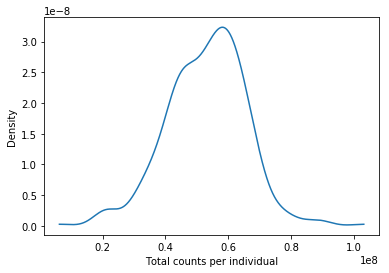

Count statistics:
  min:  6231205 
  mean: 52995255.33866667 
  max:  103219262


In [40]:
total_counts = np.sum(counts, axis=0)  # sum columns together
                                       # (axis=1 would sum rows)

from scipy import stats

# Use Gaussian smoothing to estimate the density
density = stats.kde.gaussian_kde(total_counts)

# Make values for which to estimate the density, for plotting
x = np.arange(min(total_counts), max(total_counts), 10000)

# Make the density plot
fig, ax = plt.subplots()
ax.plot(x, density(x))
ax.set_xlabel("Total counts per individual")
ax.set_ylabel("Density")

plt.show()

print('Count statistics:\n  min:  {}'.format(np.min(total_counts)),
      '\n  mean: {}'.format(np.mean(total_counts)),
      '\n  max:  {}'.format(np.max(total_counts)))

<!-- caption text="Density plot of gene expression counts per individual using KDE smoothing" -->

We can see that there is an order of magnitude difference in the total number of counts between the lowest and the highest individual.
This means that a different number of RNAseq reads were generated for each individual.
We say that these individuals have different library sizes.

#### Normalizing library size between samples

Let's take a closer look at ranges of gene expression for each individual, so when
we apply our normalization we can see it in action. We'll subset a random sample
of just 70 columns to keep the plotting from getting too messy.

In [41]:
# Subset data for plotting
np.random.seed(seed=7) # Set seed so we will get consistent results
# Randomly select 70 samples
samples_index = np.random.choice(range(counts.shape[1]), size=70, replace=False)
counts_subset = counts[:, samples_index]

In [42]:
# Some custom x-axis labelling to make our plots easier to read
def reduce_xaxis_labels(ax, factor):
    """Show only every ith label to prevent crowding on x-axis
        e.g. factor = 2 would plot every second x-axis label,
        starting at the first.

    Parameters
    ----------
    ax : matplotlib plot axis to be adjusted
    factor : int, factor to reduce the number of x-axis labels by
    """
    plt.setp(ax.xaxis.get_ticklabels(), visible=False)
    for label in ax.xaxis.get_ticklabels()[factor-1::factor]:
        label.set_visible(True)

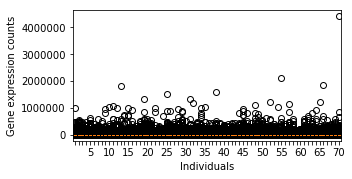

In [43]:
# Bar plot of expression counts by individual
fig, ax = plt.subplots(figsize=(4.8, 2.4))

ax.boxplot(counts_subset)
ax.set_xlabel("Individuals")
ax.set_ylabel("Gene expression counts")
reduce_xaxis_labels(ax, 5)

<!-- caption text="Boxplot of gene expression counts per individual" -->

There are obviously a lot of outliers at the high expression end of the scale and a lot of variation between individuals, but pretty hard to see because everything is clustered around zero.
So let's do log(n + 1) of our data so it's a bit easier to look at.
Both the log function and the n + 1 step can be done using broadcasting to simplify our code and speed things up.

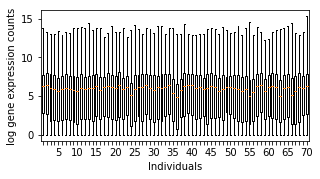

In [44]:
# Bar plot of expression counts by individual
fig, ax = plt.subplots(figsize=(4.8, 2.4))

ax.boxplot(np.log(counts_subset + 1))
ax.set_xlabel("Individuals")
ax.set_ylabel("log gene expression counts")
reduce_xaxis_labels(ax, 5)

<!-- caption text="Boxplot of gene expression counts per individual (log scale)" -->

Now let's see what happens when we normalize by library size.

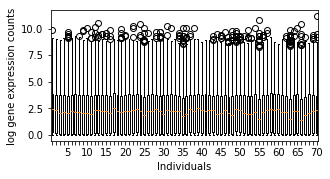

In [45]:
# Normalize by library size
# Divide the expression counts by the total counts for that individual
# Multiply by 1 million to get things back in a similar scale
counts_lib_norm = counts / total_counts * 1000000
# Notice how we just used broadcasting twice there!
counts_subset_lib_norm = counts_lib_norm[:,samples_index]

# Bar plot of expression counts by individual
fig, ax = plt.subplots(figsize=(4.8, 2.4))

ax.boxplot(np.log(counts_subset_lib_norm + 1))
ax.set_xlabel("Individuals")
ax.set_ylabel("log gene expression counts")
reduce_xaxis_labels(ax, 5)

<!-- caption text="Boxplot of library-normalized gene expression counts per individual (log scale)" -->

Much better!
Also notice how we used broadcasting twice there.
Once to divide all the gene expression counts by the total for that column, and then again to multiply all the values by 1 million.

Finally, let's compare our normalized data to the raw data.

In [46]:
import itertools as it
from collections import defaultdict


def class_boxplot(data, classes, colors=None, **kwargs):
    """Make a boxplot with boxes colored according to the class they belong to.

    Parameters
    ----------
    data : list of array-like of float
        The input data. One boxplot will be generated for each element
        in `data`.
    classes : list of string, same length as `data`
        The class each distribution in `data` belongs to.

    Other parameters
    ----------------
    kwargs : dict
        Keyword arguments to pass on to `plt.boxplot`.
    """
    all_classes = sorted(set(classes))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    class2color = dict(zip(all_classes, it.cycle(colors)))

    # map classes to data vectors
    # other classes get an empty list at that position for offset
    class2data = defaultdict(list)
    for distrib, cls in zip(data, classes):
        for c in all_classes:
            class2data[c].append([])
        class2data[cls][-1] = distrib

    # then, do each boxplot in turn with the appropriate color
    fig, ax = plt.subplots()
    lines = []
    for cls in all_classes:
        # set color for all elements of the boxplot
        for key in ['boxprops', 'whiskerprops', 'flierprops']:
            kwargs.setdefault(key, {}).update(color=class2color[cls])
        # draw the boxplot
        box = ax.boxplot(class2data[cls], **kwargs)
        lines.append(box['whiskers'][0])
    ax.legend(lines, all_classes)
    return ax

Now we can plot a colored boxplot according to normalized vs unnormalized samples.
We show only three samples from each class for illustration:

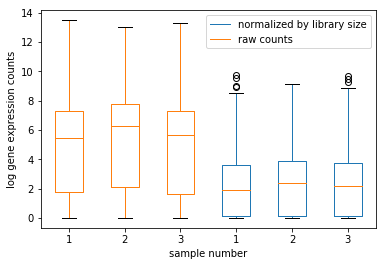

In [47]:
log_counts_3 = list(np.log(counts.T[:3] + 1))
log_ncounts_3 = list(np.log(counts_lib_norm.T[:3] + 1))
ax = class_boxplot(log_counts_3 + log_ncounts_3,
                   ['raw counts'] * 3 + ['normalized by library size'] * 3,
                   labels=[1, 2, 3, 1, 2, 3])
ax.set_xlabel('sample number')
ax.set_ylabel('log gene expression counts');

<!-- caption text="Comparing raw and library normalized gene expression counts in three samples (log scale)" -->

You can see that the normalized distributions are a little bit more similar
once we have taken library size (the sum of those distributions) into account.
Now we are comparing like with like between the samples!
But what about differences between the genes?

### Between genes

We can also get into some trouble when trying to compare different genes.
The number of counts for a gene is related to the gene length.
Suppose Gene B is twice as long as gene A.
Both are expressed at similar levels in the sample, i.e. both produce a similar number of mRNA molecules.
Remember that in RNAseq experiment, we fragment the transcripts, and sample reads from that pool of fragments.
So if a gene is twice as long, it'll produce twice as many fragments, and we are twice as likely to sample it.
Therefore you would expect gene B to have about twice as many counts as gene A.
If we want to compare the expression levels of different genes, we will have to do some more normalization.

<img src="./figures/gene_length_counts.png"/>
<!-- caption text="Relationship between counts and gene length" -->

Let's see if the relationship between gene length and counts plays out in our data set.

In [48]:
def binned_boxplot(x, y, *,  # check out this Python 3 exclusive! (*see tip box)
                   xlabel='gene length (log scale)',
                   ylabel='average log counts'):
    """Plot the distribution of `y` dependent on `x` using many boxplots.

    Note: all inputs are expected to be log-scaled.

    Parameters
    ----------
    x: 1D array of float
        Independent variable values.
    y: 1D array of float
        Dependent variable values.
    """
    # Define bins of `x` depending on density of observations
    x_hist, x_bins = np.histogram(x, bins='auto')

    # Use `np.digitize` to number the bins
    # Discard the last bin edge because it breaks the right-open assumption
    # of `digitize`. The max observation correctly goes into the last bin.
    x_bin_idxs = np.digitize(x, x_bins[:-1])

    # Use those indices to create a list of arrays, each containing the `y`
    # values corresponding to `x`s in that bin. This is the input format
    # expected by `plt.boxplot`
    binned_y = [y[x_bin_idxs == i]
                for i in range(np.max(x_bin_idxs))]
    fig, ax = plt.subplots(figsize=(4.8,1))

    # Make the x-axis labels using the bin centers
    x_bin_centers = (x_bins[1:] + x_bins[:-1]) / 2
    x_ticklabels = np.round(np.exp(x_bin_centers)).astype(int)

    # make the boxplot
    ax.boxplot(binned_y, labels=x_ticklabels)

    # show only every 10th label to prevent crowding on x-axis
    reduce_xaxis_labels(ax, 10)

    # Adjust the axis names
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel);

In [49]:
log_counts = np.log(counts_lib_norm + 1)
mean_log_counts = np.mean(log_counts, axis=1)  # across samples
log_gene_lengths = np.log(gene_lengths)

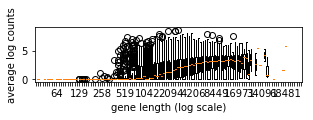

In [50]:
binned_boxplot(x=log_gene_lengths, y=mean_log_counts)

<!-- caption text="The relationship between gene length and average expression (log scale)" -->

We can see that the longer a gene is, the higher its measured counts! As
explained above, this is an artifact of the technique, not a biological signal!
How do we account for this?

### Normalizing over samples and genes: RPKM

One of the simplest normalization methods for RNAseq data is RPKM: reads per
kilobase transcript per million reads.
RPKM puts together the ideas of normalising by sample and by gene.
When we calculate RPKM, we are normalizing for both the library size (the sum of each column)
and the gene length.

To work through how RPKM is derived, let's define the following values:

- $C$ = Number of reads mapped to a gene
- $L$ = exon length in base-pairs for a gene
- $N$ = Total mapped reads in the experiment

First, let's calculate reads per kilobase.

Reads per base would be:
$\frac{C}{L}$

The formula asks for reads per kilobase instead of reads per base.
One kilobase = 1000 bases, so we'll need to divide length (L) by 1000.

Reads per kilobase would be:

$\frac{C}{L/1000}  = \frac{10^3C}{L}$

Next, we need to normalize by library size.
If we just divide by the number of mapped reads we get:

$ \frac{10^3C}{LN} $

But biologists like thinking in millions of reads so that the numbers don't get
too big. Counting per million reads we get:

$ \frac{10^3C}{L(N/10^6)} = \frac{10^9C}{LN}$


In summary, to calculate reads per kilobase transcript per million reads:
$RPKM = \frac{10^9C}{LN}$

Now let's implement RPKM over the entire counts array.

In [51]:
# Make our variable names the same as the RPKM formula so we can compare easily
C = counts
N = counts.sum(axis=0)  # sum each column to get total reads per sample
L = gene_lengths  # lengths for each gene, matching rows in `C`

First, we multiply by 10^9.
Because counts (C) is an ndarray, we can use broadcasting.
If we multiple an ndarray by a single value,
that value is broadcast over the entire array.

In [52]:
# Multiply all counts by 10^9
C_tmp = 10^9 * C

Next we need to divide by the gene length.
Broadcasting a single value over a 2D array was pretty clear.
We were just multiplying every element in the array by the value.
But what happens when we need to divide a 2D array by a 1D array?

#### Broadcasting rules

Broadcasting allows calculations between ndarrays that have different shapes.
Numpy uses broadcasting rules to make these manipulations a little easier.
When two arrays have the same number of dimensions,
broadcasting can occur if the sizes of each dimension match,
or one of them is equal to 1.
If arrays have different numbers of dimensions, then $(1,)$ is prepended to the
shorter array until the numbers match, and then the standard broadcasting rules
apply.

For example, suppose we have two ndarrays, A and B, with shapes $(5, 2)$ and
$(2,)$.
We define the product `A * B` using broadcasting.
B has fewer dimensions than A, so during the calculation,
a new dimension is prepended to B with value 1, so B's new shape is $(1, 2)$.
Finally, where B's shape doesn't match A's, it is *multiplied* by stacking enough
versions of B, giving the shape $(5, 2)$. This is done "virtually", without using
up any additional memory. At this point, the product is just an element-wise
multiplication, giving an output array of the same shape as A.

Now let's say we have another array, C, of shape $(2, 5)$. To multiply (or add) C 
to B, we might try to prepend $(1,)$ to the shape of B, but in that case, we still
end up with incompatible shapes: $(2, 5)$ and $(1, 2)$. If we want the arrays to
broadcast, we have to *ap*pend a dimension to B, manually. Then, we end up with
$(2, 5)$ and $(2, 1)$, and broadcasting can proceed.

In NumPy, we can explicitly add a new dimension to B using `np.newaxis`.
Let's see this in our normalization by RPKM.

Let's look at the dimensions of our arrays.

In [53]:
print('C_tmp.shape', C_tmp.shape)
print('L.shape', L.shape)

C_tmp.shape (20500, 375)
L.shape (20500,)


We can see that `C_tmp` has 2 dimensions, while L has one.
So during broadcasting, an additional dimension will be prepended to L.
Then we will have:
```
C_tmp.shape (20500, 375)
L.shape (1, 20500)
```
The dimensions won't match!
We want to broadcast L over the first dimension of `C_tmp`,
so we need to adjust the dimensions of L ourselves.

In [54]:
L = L[:, np.newaxis] # append a dimension to L, with value 1
print('C_tmp.shape', C_tmp.shape)
print('L.shape', L.shape)

C_tmp.shape (20500, 375)
L.shape (20500, 1)


Now that our dimensions match or are equal to 1, we can broadcast.

In [55]:
# Divide each row by the gene length for that gene (L)
C_tmp = C_tmp / L

Finally we need to normalize by the library size,
the total number of counts for that column.
Remember that we have already calculated N with:
```
N = counts.sum(axis=0) # sum each column to get total reads per sample
```
Once we trigger broadcasting, an additional dimension will be
prepended to N:

`N.shape (1, 375)`

The dimensions will match so we don't have to do anything.
However, for readability, it can be useful to add the extra dimension to N anyway.

In [ ]:
# Divide each column by the total counts for that column (N)
N = N[np.newaxis, :]
print('C_tmp.shape', C_tmp.shape)
print('N.shape', N.shape)

In [56]:
# Divide each column by the total counts for that column (N)
rpkm_counts = C_tmp / N

#### Exercise: RPKM function
Write a function using the following docstring and the code we just went through above.

In [57]:
def rpkm(counts, lengths):
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    
    C_tmp = counts
    L = lengths
    C_tmp = C_tmp * 10^9
    L = L[:, np.newaxis]
    C_tmp = C_tmp / L
    N = counts.sum(axis=0)
    normed = C_tmp / N
    return normed

In [58]:
# test your function with this code
counts_rpkm = rpkm(counts, gene_lengths)

#### RPKM between gene normalization

Let's see the RPKM normalization's effect in action. First, as a reminder, here's
the distribution of mean log counts as a function of gene length:

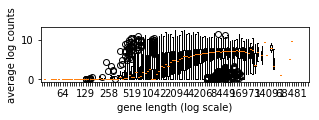

In [59]:
log_counts = np.log(counts + 1)
mean_log_counts = np.mean(log_counts, axis=1)
log_gene_lengths = np.log(gene_lengths)

binned_boxplot(x=log_gene_lengths, y=mean_log_counts)

<!-- caption text="The relationship between gene length and average expression before RPKM normalization (log scale)" -->

Now, the same plot with the RPKM-normalized values:

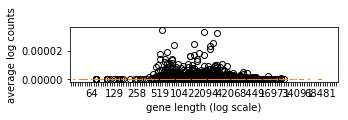

In [60]:
log_counts = np.log(counts_rpkm + 1)
mean_log_counts = np.mean(log_counts, axis=1)
log_gene_lengths = np.log(gene_lengths)

binned_boxplot(x=log_gene_lengths, y=mean_log_counts)

<!-- caption text="The relationship between gene length and average expression after RPKM normalization (log scale)" -->

You can see that the mean expression counts have flattened quite a bit,
especially for genes larger than about 3,000 base pairs.
(Smaller genes still appear to have low expression — these may be too small for
the statistical power of the RPKM method.)

RPKM normalization can be useful to compare the expression profile of different genes.
We've already seen that longer genes have higher counts, but this doesn't mean their expression level is actually higher.
Let's choose a short gene and a long gene and compare their counts before and after RPKM normalization to see what we mean.

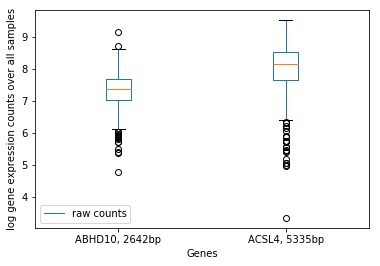

In [62]:
gene_idxs = np.array([80, 186])
gene1, gene2 = gene_names[gene_idxs]
len1, len2 = gene_lengths[gene_idxs]
gene_labels = ['{}, {}bp'.format(gene1,len1,), '{}, {}bp'.format(gene2,len2)]

log_counts = list(np.log(counts[gene_idxs] + 1))
log_ncounts = list(np.log(counts_rpkm[gene_idxs] + 1))

ax = class_boxplot(log_counts,
                   ['raw counts'] * 3,
                   labels=gene_labels)
ax.set_xlabel('Genes')
ax.set_ylabel('log gene expression counts over all samples');

<!-- caption text="Comparing expression of two genes before RPKM normalization" -->

If we look just at the raw counts, it looks like the longer Gene B is expressed
slightly more than Gene A.
But, after RPKM normalization, a different picture emerges:

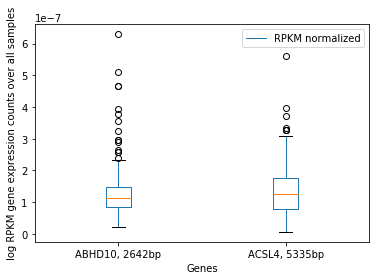

In [63]:
ax = class_boxplot(log_ncounts,
                   ['RPKM normalized'] * 3,
                   labels=gene_labels)
ax.set_xlabel('Genes')
ax.set_ylabel('log RPKM gene expression counts over all samples');

<!-- caption text="Comparing expression of two genes after RPKM normalization" -->

Now it looks like gene A is actually expressed at a much higher level than gene B.
This is because RPKM includes normalization for gene length, so we can now directly compare between genes of different lengths.

In the next lesson, we will continue working with the same data set, implementing a
more sophisticated normalization technique, then using clustering to make some
predictions about mortality in skin cancer patients.

## Key points
- The `numpy` library provides Python with an array object that is optimized for memory usage and speed.
- Use `ndarray`s whenever you need to work with data
- **Vectorization** is where you apply a calculation to each element in an array, without having to use a `for` loop.
- **Broadcasting** allows for implicit operations on arrays
- Use vectorization and broadcasting to make array operations more efficient and concise.